### Newborn jaundice is very common—about 3 in 5 babies (60 percent) have jaundice. If a baby has severe jaundice and doesn't get quick treatment, it can lead to brain damage.

#### Importing necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir_normal = '../Dataset/Jaundice-Prediction/normal'
data_dir_jaundice = '../Dataset/Jaundice-Prediction/jaundice'

In [3]:
# converting data directory into a pathlib
import pathlib
data_dir_normal= pathlib.Path(data_dir_normal)
data_dir_normal

PosixPath('../Dataset/Jaundice-Prediction/normal')

In [4]:
data_dir_jaundice= pathlib.Path(data_dir_jaundice)
data_dir_jaundice

PosixPath('../Dataset/Jaundice-Prediction/jaundice')

In [5]:
list(data_dir_jaundice.glob('*.jpg'))[:5]

[PosixPath('../Dataset/Jaundice-Prediction/jaundice/jaundice (174).jpg'),
 PosixPath('../Dataset/Jaundice-Prediction/jaundice/jaundice (29).jpg'),
 PosixPath('../Dataset/Jaundice-Prediction/jaundice/jaundice (91).jpg'),
 PosixPath('../Dataset/Jaundice-Prediction/jaundice/jaundice (123).jpg'),
 PosixPath('../Dataset/Jaundice-Prediction/jaundice/jaundice (135).jpg')]

In [6]:
normal_image_count = len(list(data_dir_normal.glob('*.jpg')))
jaundice_image_count = len(list(data_dir_jaundice.glob('*.jpg')))
print(normal_image_count, jaundice_image_count)

560 200


#### Visualise Raw Data

In [7]:
normal = list(data_dir_normal.glob('*.jpg'))
jaundice = list(data_dir_jaundice.glob('*.jpg'))

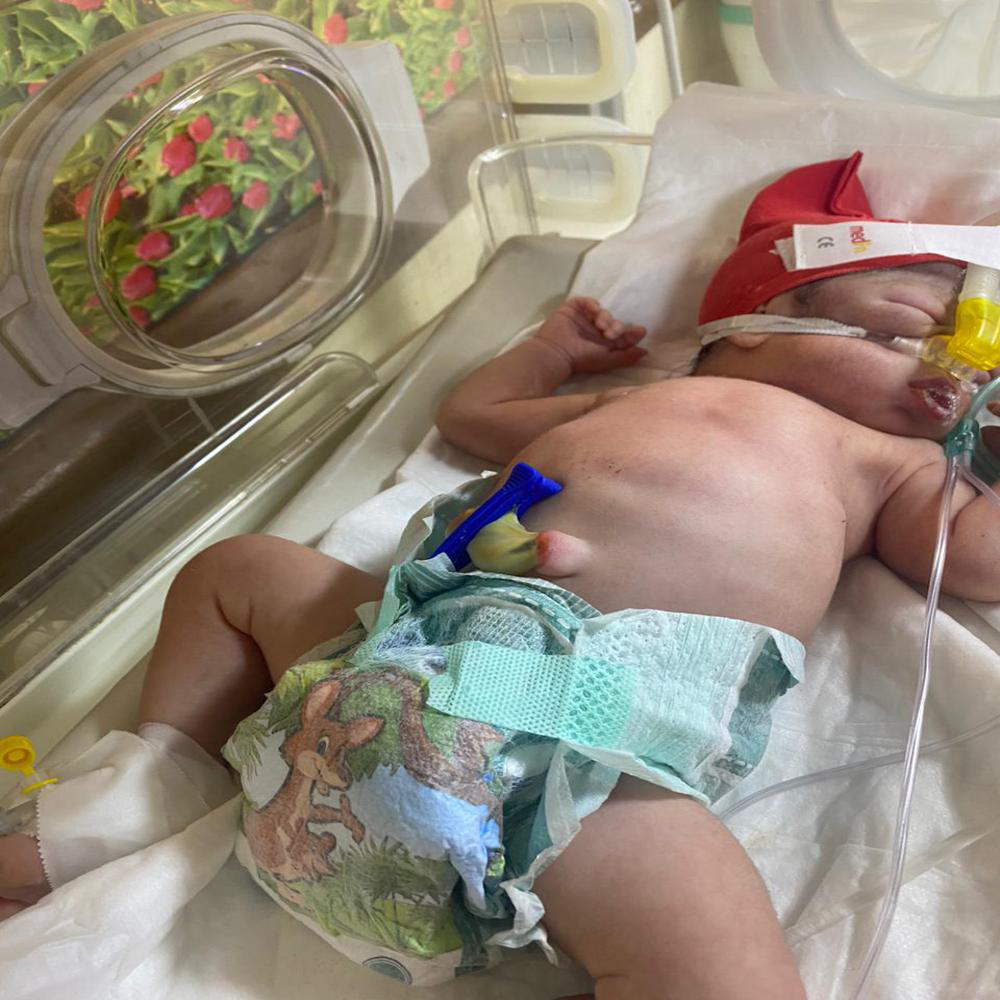

In [8]:
PIL.Image.open(str(normal[1]))

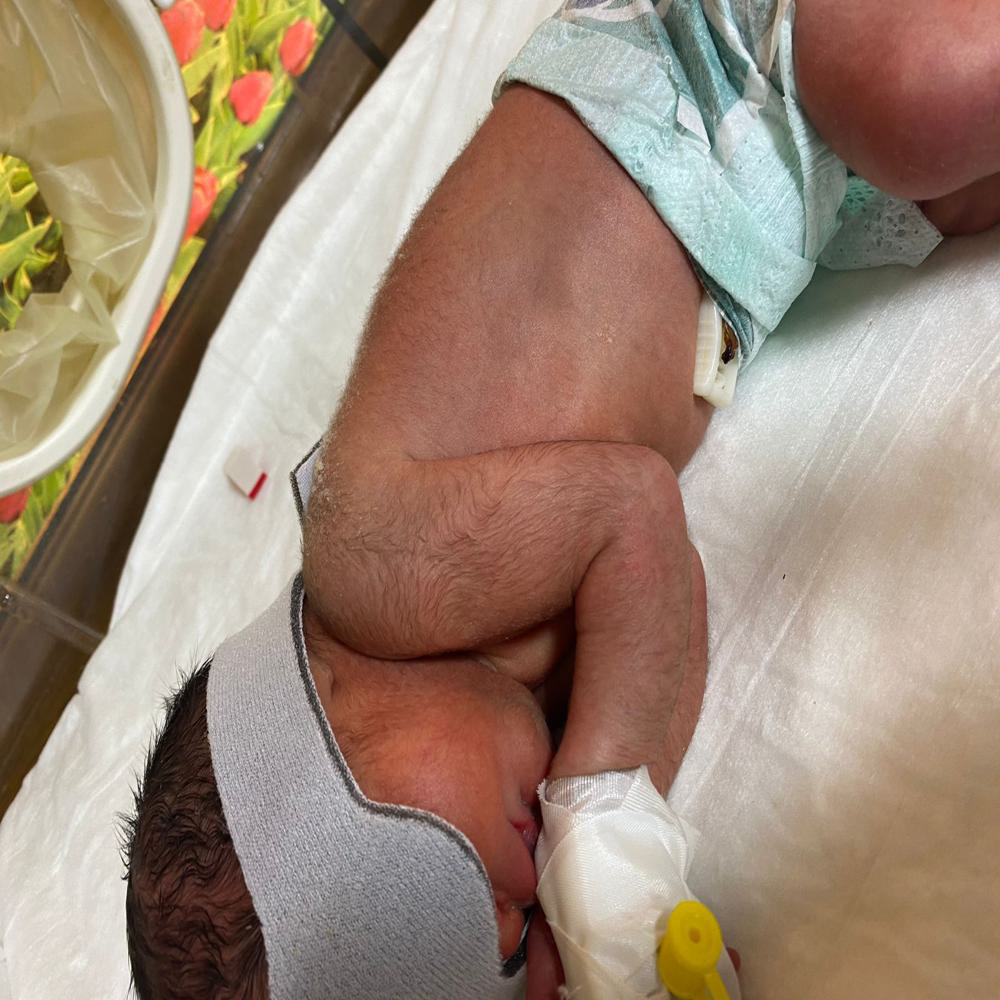

In [9]:
PIL.Image.open(str(jaundice[1]))

#### Read images from disk into numpy array using opencv

In [10]:
images_dict = {
    'normal': normal,
    'jaundice':jaundice
}

In [11]:
labels_dict = {
    'normal':1,
    'jaundice':0
}

In [12]:
img = cv2.imread(str(images_dict['jaundice'][20]))
img.shape

(1000, 1000, 3)

In [13]:
X, y = [], []

for target, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(1000,1000))
        X.append(resized_img)
        y.append(labels_dict[target])

In [14]:
# Turning X and y into numpy arrays
X = np.array(X)
y = np.array(y)

#### Check the class distribution in raw data

In [15]:
print('# of Samples:', len(y))
print('# of jaundice:', (y == 0).sum())
print('# of normal:', (y == 1).sum())

# of Samples: 760
# of jaundice: 200
# of normal: 560


#### Train Test Validation Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [17]:
print('X_train: ', len(X_train))
print('X_test:', len(X_test))
print('X_val:', len(X_val))

X_train:  456
X_test: 190
X_val: 114


In [18]:
from collections import Counter

In [19]:
Counter(y_train)

Counter({1: 341, 0: 115})

In [20]:
Counter(y_test)

Counter({0: 52, 1: 138})

#### Scaling Images

In [21]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

#### Building CNN Model

In [22]:
# we have 2 image classes
num_classes = 2

model = Sequential([
    
#  feature extraction
    
# CONV_1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
# POOL_1
  layers.MaxPooling2D(),
# CONV_2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
# POOL_2
  layers.MaxPooling2D(),
# CONV_3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
# POOL_3
  layers.MaxPooling2D(),
# DROPOUT_1
  layers.Dropout(0.2),
    
#  image classification
    
# FLATTEN
  layers.Flatten(),
# DENSE_1
  layers.Dense(128, activation='relu'),
# DENSE_2
  layers.Dense(num_classes)
])
  

#### Setup Callbacks

In [23]:
callbk=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
my_callbacks = [callbk]

#### Training

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
               

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=30,validation_data=(X_val_scaled, y_val),callbacks=my_callbacks) 

#### Evaluating the Model

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred

In [ ]:
y_pred = tf.nn.softmax(y_pred)
y_pred

In [ ]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes

In [ ]:
train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
test_acc

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report: \n",classification_report(y_test,y_classes))

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_classes)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Extract Layer Weights

In [ ]:
model.get_layer(index=1).weights

#### Extract Feature Map

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=4).output,
)

In [ ]:
test_arr = np.expand_dims(X_test_scaled[0],axis=0)

In [ ]:
features = feature_extractor(test_arr)

In [ ]:
features_arr=np.swapaxes(features[0], 0, 2)[2]

In [ ]:
pyplot.imshow(features_arr)